# Melanoma TME (Tirosh et al.)

In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats

sc.settings.verbosity = 3

In [2]:
# import sys
# sys.path.insert(0,'..')
import scmer

## 0. Get your environment ready

1. Download data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056
2. Get your conda environment ready with scanpy and scmer
   ```
   > conda create -n py311_scmer python=3.11 jupyter git
   > conda activate py311_scmer
   > conda install -c conda-forge scanpy python-igraph leidenalg
   > pip install git+https://github.com/KChen-lab/SCMER
   > git clone https://github.com/KChen-lab/SCMER
   ```
   We also confirmed that python 3.10 works. Other versions >=3.7 and <3.10 should also work.
3. Install pytorch with GPU support (ref. https://pytorch.org/get-started/locally/)
   ```
   > pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
   ```
   You can try an earlier version if your GPU does not support the latest version.
4. Run this script (`notebooks/melanoma-gpu.ipynb`)

Data Source: Tirosh I, Izar B, Prakadan SM, Wadsworth MH 2nd et al. Dissecting the multicellular ecosystem of metastatic melanoma by single-cell RNA-seq. Science 2016 Apr 8;352(6282):189-96.

In [3]:
# You may use this to test if torch works properly with GPU
# import torch
# torch.cuda.is_available()
# torch.Tensor([1]).cuda() * torch.Tensor([2]).cuda()

## 1. Load and clean data

### 1.1 Preprocessing

We first rename duplicate gene names.

In [4]:
data = pd.read_table("../data/GSE72056_melanoma_single_cell_revised_v2.txt.gz", header=0)
def dedup(x):
    d = {}
    r = []
    for i in x:
        if i in d:
            d[i] += 1
            r.append(i + '_' + str(d[i]))
            print(i, 'renamed to', r[-1])
        else:
            d[i] = 1
            r.append(i)
    return r

data['Cell'] = dedup(data['Cell'])

data = data.T

data.columns = data.loc["Cell"]
data.drop('Cell', inplace=True)
data

MARCH2 renamed to MARCH2_2
MARCH1 renamed to MARCH1_2


Cell,tumor,"malignant(1=no,2=yes,0=unresolved)","non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)",C9orf152,RPS11,ELMO2,CREB3L1,PNMA1,MMP2,TMEM216,...,GPLD1,SNORD115-39,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
Cy72_CD45_H02_S758_comb,72.0,1.0,2.0,0.0,9.2172,0.0,0.0,0.0,0.0,0.0,...,0.62667,0.0,0.0,0.0,0.0,7.6069,0.0,0.0,2.6638,0.0
CY58_1_CD45_B02_S974_comb,58.0,1.0,1.0,0.0,8.3745,0.0,0.0,0.0,0.0,0.0,...,1.0545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.9901,0.0
Cy71_CD45_D08_S524_comb,71.0,2.0,0.0,0.0,9.313,2.1263,0.0,0.0,0.73812,0.0,...,0.99639,0.0,2.7634,0.0,3.6782,0.0,3.9871,3.8777,1.6126,0.0
Cy81_FNA_CD45_B01_S301_comb,81.0,2.0,0.0,0.0,7.8876,0.0,0.0,0.0,0.0,0.0,...,0.23143,0.0,4.1937,0.0,0.0,0.0,5.2639,3.766,4.8417,0.0
Cy80_II_CD45_B07_S883_comb,80.0,2.0,0.0,0.0,8.3291,0.0,0.0,0.0,0.0,3.7949,...,0.0,0.0,2.5705,0.0,0.0,0.0,6.0824,1.7816,4.4607,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CY75_1_CD45_CD8_7__S223_comb,75.0,1.0,1.0,0.0,5.4889,0.0,0.0,0.0,0.0,0.0,...,1.2962,0.0,0.0,0.0,0.0,0.0,6.0986,0.0,3.6464,0.0
CY75_1_CD45_CD8_1__S65_comb,75.0,1.0,1.0,0.0,4.9262,5.5296,0.0,0.0,0.0,0.0,...,0.99245,0.0,0.0,0.0,5.5465,3.7384,0.0,0.0,7.0004,0.0
CY75_1_CD45_CD8_1__S93_comb,75.0,1.0,1.0,0.0,7.0958,0.0,0.0,0.0,0.0,0.0,...,0.97516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.9615,0.0
CY75_1_CD45_CD8_1__S76_comb,75.0,1.0,1.0,0.0,3.997,0.0,0.0,0.0,0.0,0.0,...,0.49208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.1918,0.0


We then separate metadata from gene expression and remove ERCC spike-ins. 

In [5]:
obs = data[['tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)']]
data.drop(['tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)'], 
          axis=1, inplace=True)
print(*data.columns[data.columns.str.startswith('ERCC')], 'are dropped')
data = data.loc[:, data.columns.str.startswith('ERCC') == False]

obs

ERCC5 ERCC8 ERCC1 ERCC4 ERCC6L ERCC6L2 ERCC3 ERCC6 ERCC2 are dropped


Cell,tumor,"malignant(1=no,2=yes,0=unresolved)","non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)"
Cy72_CD45_H02_S758_comb,72.0,1.0,2.0
CY58_1_CD45_B02_S974_comb,58.0,1.0,1.0
Cy71_CD45_D08_S524_comb,71.0,2.0,0.0
Cy81_FNA_CD45_B01_S301_comb,81.0,2.0,0.0
Cy80_II_CD45_B07_S883_comb,80.0,2.0,0.0
...,...,...,...
CY75_1_CD45_CD8_7__S223_comb,75.0,1.0,1.0
CY75_1_CD45_CD8_1__S65_comb,75.0,1.0,1.0
CY75_1_CD45_CD8_1__S93_comb,75.0,1.0,1.0
CY75_1_CD45_CD8_1__S76_comb,75.0,1.0,1.0


In [6]:
pd.crosstab(obs['malignant(1=no,2=yes,0=unresolved)'], obs['non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)'])

"non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)",0.0,1.0,2.0,3.0,4.0,5.0,6.0
"malignant(1=no,2=yes,0=unresolved)",,,,,,,
0.0,90,24,3,6,3,5,1
1.0,416,2040,512,119,62,56,51
2.0,1252,4,0,1,0,0,0


In [7]:
# Suppress SettingWithCopyWarning
import warnings
import pandas as pd
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Rename cell types for better appearance

malignant_dict = ['unresolved', 'normal', 'malignant']
celltype_dict = ['bordercase', 'T', 'B', 'Macro', 'Endo', 'CAF', 'NK']
obs['tumor'] = obs['tumor'].apply(lambda x: 'Mel' + str(int(x)))
obs['malignant'] = obs['malignant(1=no,2=yes,0=unresolved)'].astype(int).apply(malignant_dict.__getitem__)
obs['celltype'] = obs['non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)'].astype(int).apply(celltype_dict.__getitem__)
obs['patient'] = data.index.str.split('-|_', regex=True).str[0].str[:4].str.lower()
obs.loc[obs['malignant'] == 'malignant', 'celltype'] = 'malignant'

C:\Users\lshh\AppData\Local\Temp\ipykernel_24516\3669031727.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['tumor'] = obs['tumor'].apply(lambda x: 'Mel' + str(int(x)))
C:\Users\lshh\AppData\Local\Temp\ipykernel_24516\3669031727.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs['malignant'] = obs['malignant(1=no,2=yes,0=unresolved)'].astype(int).apply(malignant_dict.__getitem__)
C:\Users\lshh\AppData\Local\Temp\ipykernel_24516\3669031727.py:13: SettingWithCopyWarning: 
A value is trying to b

### 1.2 Create AnnData for scanpy

In [8]:
adata = sc.AnnData(data)
for i in obs.columns:
    adata.obs[i] = obs[i]

In [9]:
adata

AnnData object with n_obs × n_vars = 4645 × 23677
    obs: 'tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)', 'malignant', 'celltype', 'patient'

## 2 Typical SCANPY analysis

### 2.1 QC

normalizing counts per cell
    finished (0:00:02)


C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

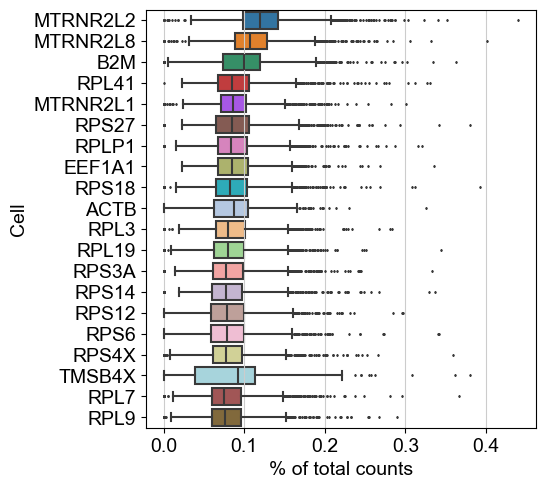

In [10]:
sc.settings.set_figure_params(dpi=50, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

No mitochonrial genes available, which is okay.

In [11]:
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [12]:
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1397 genes that are detected in less than 3 cells


### 2.2 Normalization, HVG Selection, and Scaling

In [14]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:01)


In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes


C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


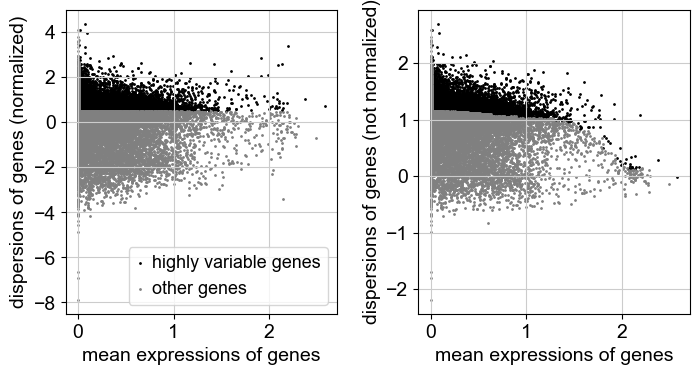

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata

In [18]:
adata = adata[:, adata.var.highly_variable]

In [19]:
sc.pp.scale(adata, max_value=10)

C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
adata

AnnData object with n_obs × n_vars = 4645 × 6219
    obs: 'tumor', 'malignant(1=no,2=yes,0=unresolved)', 'non-malignant cell type (1=T,2=B,3=Macro.4=Endo.,5=CAF;6=NK)', 'malignant', 'celltype', 'patient', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

### 2.3 Dimensional Reduction

In [21]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)


C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_m

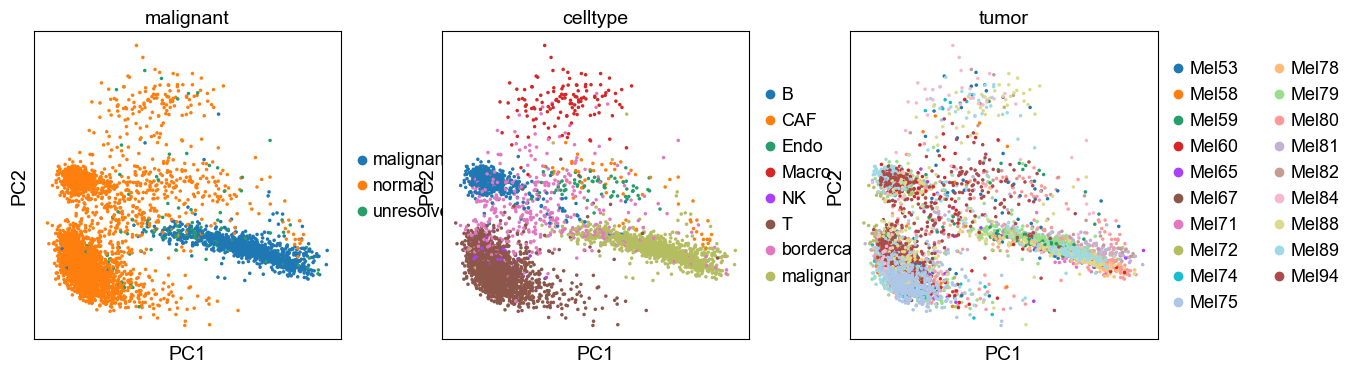

In [22]:
sc.pl.pca(adata, color=['malignant', 'celltype', 'tumor'])

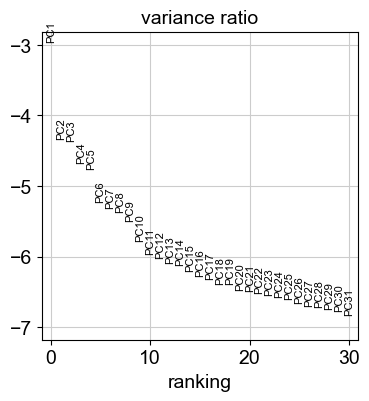

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_m

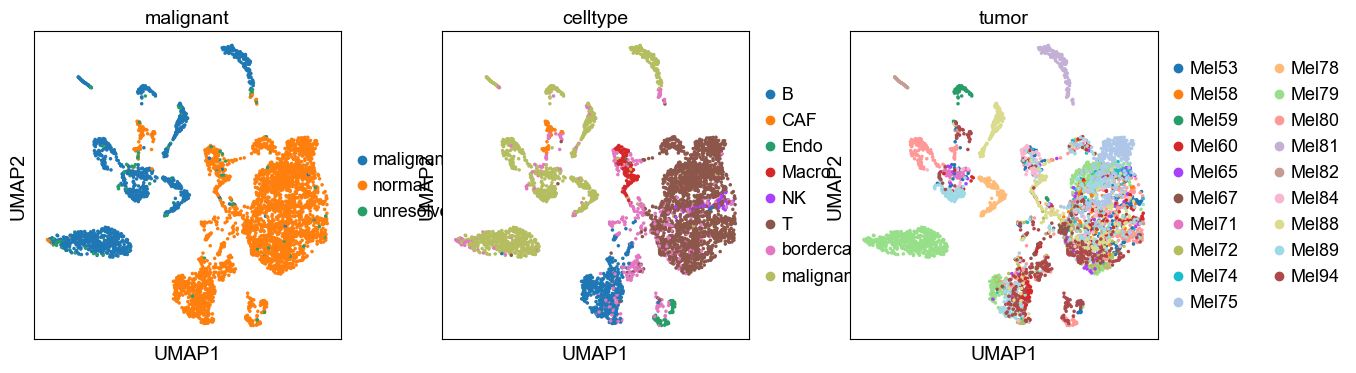

In [24]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['malignant', 'celltype', 'tumor'])

## 3. SCMER Feature Selection

Each step contains 20 inner iterations. It can be seen that the algorithm converges in 40~60 iternations.

As a rule of thumb, the loss should end up with 3.0~4.0. 
0.0 is perfect but it needs many features. 
A loss greater than 4.0 usually mean that the manifold is not well retained.

In [25]:

model = scmer._umap_l1.UmapL1(lasso=5e-4, n_pcs=20, 
                              perplexity=30., use_beta_in_Q=True, n_threads=12, use_gpu=True) # , max_inner_iter=1, max_outer_iter=1
model.fit(adata.X)

Calculating distance matrix and scaling factors...
Computing pairwise distances...
Using 12 threads...
Mean value of sigma: 1.017822
Done. Elapsed time: 12.61 seconds. Total: 12.61 seconds.
Creating model without batches...
Optimizing using OWLQN (because lasso is nonzero)...
0 loss (before this step): 7.537274360656738 Nonzero (after): 34 Elapsed time: 3.66 seconds. Total: 16.27 seconds.
1 loss (before this step): 3.64192795753479 Nonzero (after): 34 Elapsed time: 2.02 seconds. Total: 18.28 seconds.
2 loss (before this step): 3.6367321014404297 Nonzero (after): 34 Elapsed time: 2.64 seconds. Total: 20.92 seconds.
3 loss (before this step): 3.636669874191284 Nonzero (after): 34 Elapsed time: 1.10 seconds. Total: 22.02 seconds.
4 loss (before this step): 3.636669874191284 Nonzero (after): 34 Elapsed time: 1.11 seconds. Total: 23.13 seconds.
Final loss: 3.5475449562072754 Nonzero: 34 Elapsed time: 0.03 seconds. Total: 23.16 seconds.


Selected markers:

In [26]:
print(*adata.var_names[model.get_mask()])

SELL B2M SERPINA3 CD55 TXNIP HLA-DRA PDCD1 LCP1 HAVCR2 A2M TYR COL1A2 CDH5 ASF1B NKG7 MFAP4 GZMA COL1A1 FOXP3 PMEL PRAME MIA IFITM1 MAGEC2 TYROBP CD69 CD27 MS4A1 LSP1 TCF7 CCL4 TOX HLA-DPA1 LTB


## 4. Validation

### 4.1 PCA and UMAP validation

The PCA and UMAP largely resemble the ones obtained from all genes.

computing PCA
    on highly variable genes
    with n_comps=33
    finished (0:00:00)


C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\preprocessing\_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action

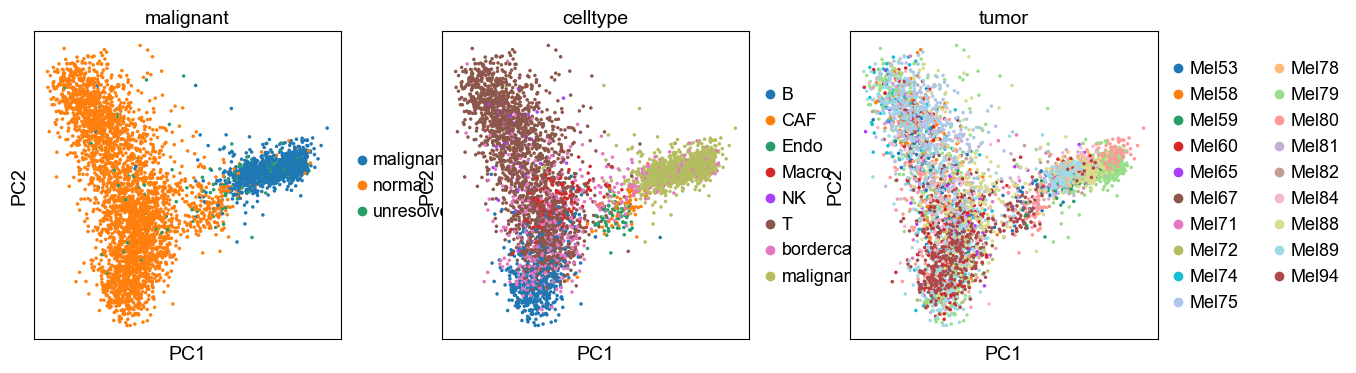

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\lshh\miniconda3\envs\py311_scmer\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_m

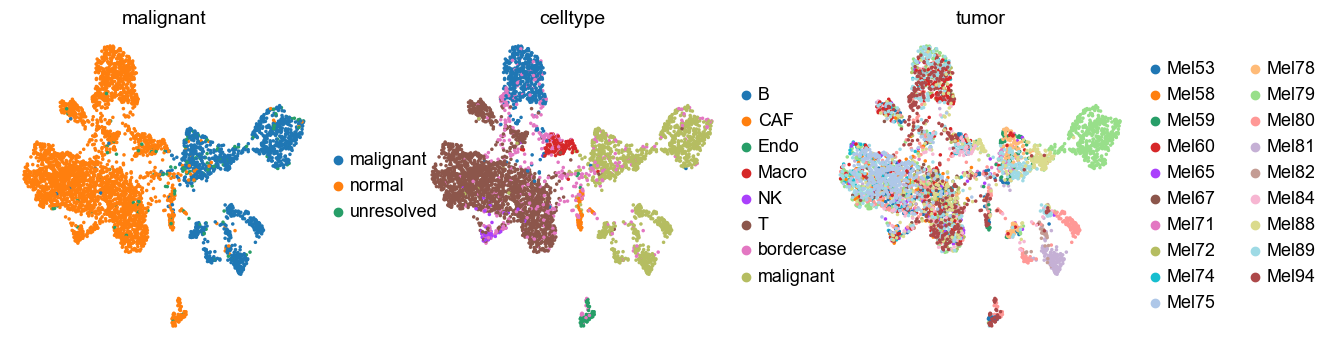

In [27]:
new_adata = model.transform(adata)
sc.tl.pca(new_adata, svd_solver='arpack')
sc.pl.pca(new_adata, color=['malignant', 'celltype', 'tumor'])
sc.pp.neighbors(new_adata, n_pcs=10, use_rep="X_pca")
sc.tl.umap(new_adata)
sc.pl.umap(new_adata, color=['malignant', 'celltype', 'tumor'], frameon=False)

### 4.2 Scatter Plot of the Selected Features

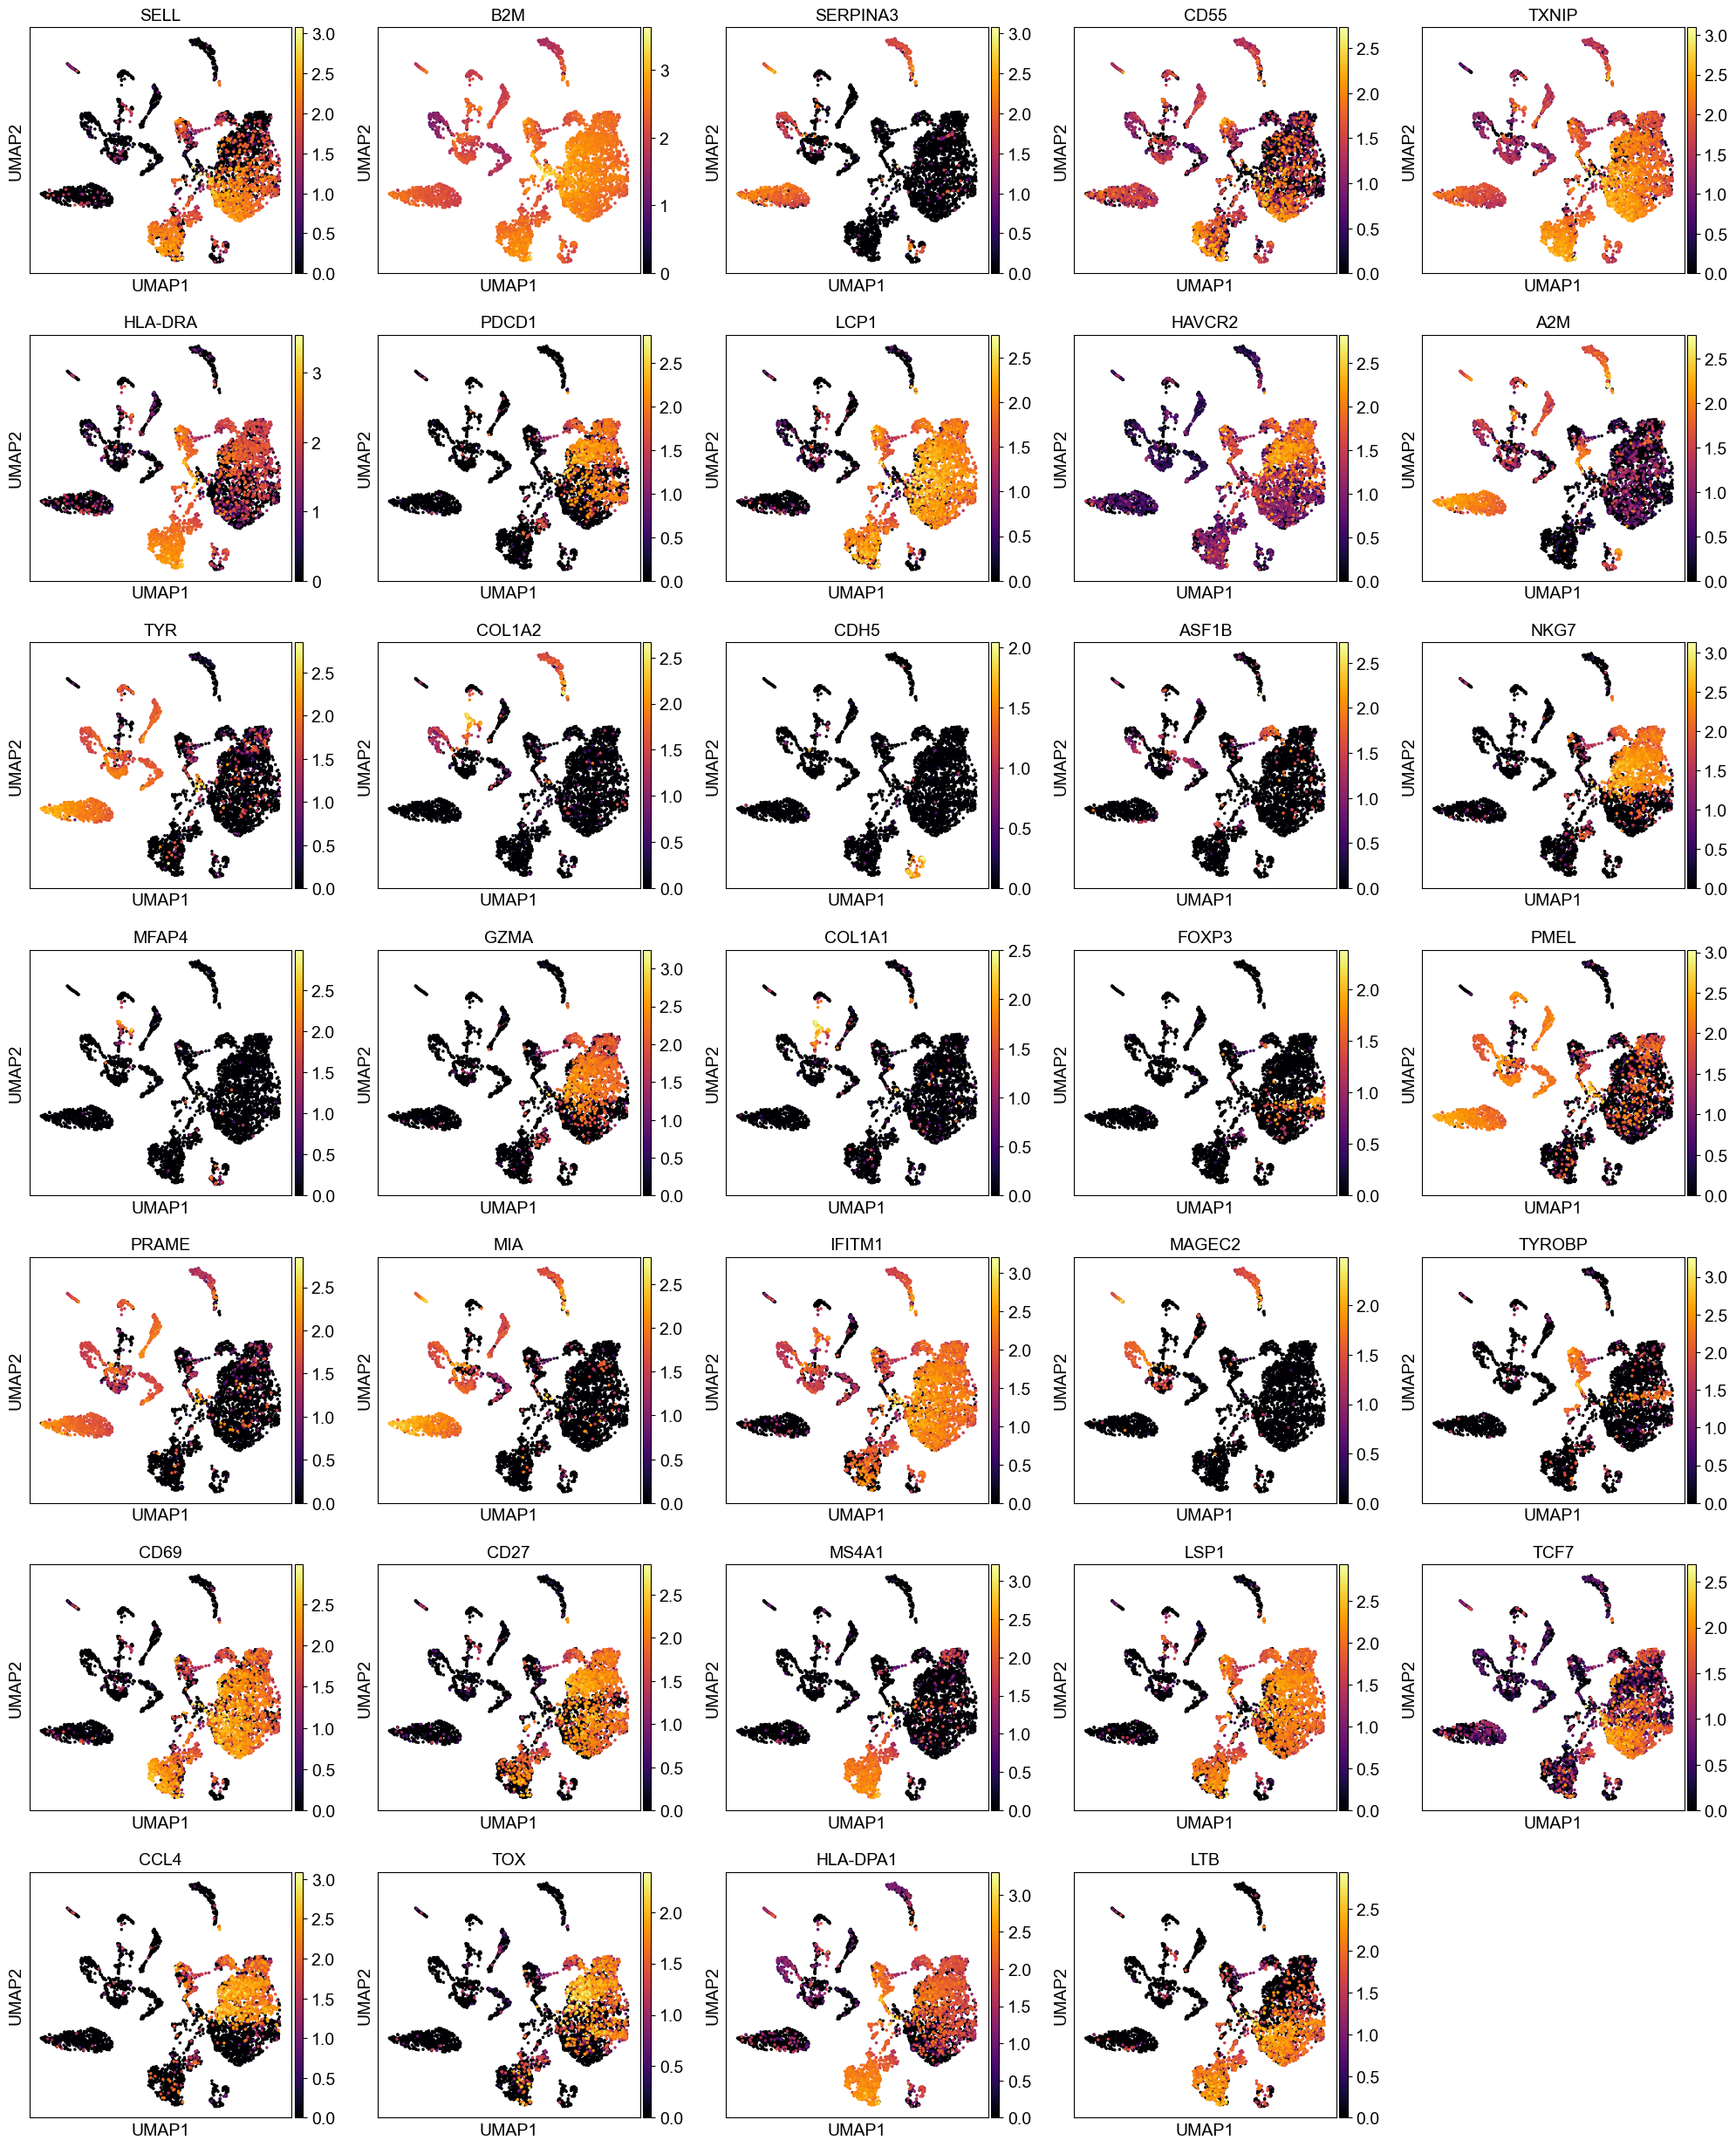

In [28]:
sc.settings.set_figure_params(dpi=50, facecolor='white')
sc.pl.umap(adata, color=adata.var_names[model.get_mask()], ncols=5, legend_loc="on data", legend_fontsize=8., color_map="inferno")

## 5. Session Info

In [29]:
sc.logging.print_versions()

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         9.4.0
anyio                       NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
backcall                    0.2.0
brotli                      1.0.9
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          2.0.4
colorama                    0.4.6
comm                        0.1.2
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
h5py                        3.9.0
idna                        3.4
igraph                      0.11.3
ipykernel                   6.25.0
ipywidgets                  8.0.4
jedi                        0.18.1
jinja2                      3.1.2
